In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error
shap.initjs()
import json
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from PyPDF2 import PdfReader
import re 
import csv
from rapidfuzz import process, fuzz
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


## Definire la directory per i file di output

In [2]:
# 1. Definisci la directory una sola volta
OUTPUT_DIR = r"C:/Users/Maria Beatrice/Desktop/test/UNIVERSITA/SECONDO anno magistrale/BIGDATA/Big-Data-Analytics/Progetto Big Data/output/clinica"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2. Funzione helper per creare il path completo
def file_path(filename):
    return os.path.join(OUTPUT_DIR, filename)

## Con questo codice si trasferisce il da file pdf a csv il file di domande di nostro interesse per gli anni 2016, 2017, 2018, 2019



## Area clinica 2016

In [3]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Clinica_2016.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"


### Si definisce il pattern con cui trovare le domande, le opzioni e segnare la risposta corretta

In [4]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)


### Condizioni per memorizzare le macro categorie in base al codice della domanda

In [5]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 416:
        return "chirurgia generale"
    elif 417 <= qid <= 642:
        return "chirurgia specialistica"
    elif 643 <= qid <= 927:
        return "medicina interna"
    elif 928 <= qid <= 1175:
        return "medicina legale e sanità pubblica"
    elif 1176 <= qid <= 2474:
        return "medicina specialistica"
    elif 2475 <= qid <= 2638:
        return "organi di senso" 
    elif 2639 <= qid <= 2893:
        return "ostetricia e ginecologia"
    elif 2894 <= qid <= 3204:
        return "pediatria"
    elif 3205 <= qid <= 3419:
        return "radiologia e diagnostica"
    else:
        return ""


In [6]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Clinica 2016",
        "macro category": macro_category_from_id(qid)
    })


In [7]:
#  
with open("area_clinica_2016_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)


In [8]:
df_2016_clinica = pd.read_csv('area_clinica_2016_domande.csv')
#df_2016_clinica.iloc[1551]

In [10]:
### SI pulisce il testo dagli errori: per esempio nelle domande a pie pagina viene inglobato il testo Area Cinica Ministero dell'istruzione..., si rendono tutti i testi minuscoli e si tolgono i doppi spazi

In [9]:
# puliamo il testo dagli errori
df = df_2016_clinica
regex_da_rimuovere = r"AREA CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()
     


In [10]:
df.to_csv(file_path("area_clinica_2016_domande_pulite.csv"), encoding='utf-8')
#pd.read_csv(file_path("area_clinica_2016_domande_pulite.csv")).iloc[1551]

In [13]:
#Si fa un check per verificare che tutte le domande siano state registrate nel File

inconsistenti = df_2016_clinica[df_2016_clinica.index != df_2016_clinica["id"] - 1]

# Mostra o salva le righe inconsistenti
print(inconsistenti)
#non ci sono osservazioni inconsistenti

Empty DataFrame
Columns: [id, question, A, B, C, D, E, answer, category, macro category]
Index: []


Si fa un check delle domande e delle risposte tra il full text e il il csv ottenuto

In [14]:
# Confrontiamo automaticamente le prime 20 domande tra PDF (testo estratto) e CSV

# Estrarre le domande dal CSV
df_sample = df_2016_clinica.copy()

# Estrarre lo stesso testo dal PDF già precedentemente letto
# Spezziamo le domande dal testo intero PDF (già caricato in `full_text`)
pdf_questions_raw = question_pattern.findall(full_text)

# Mappiamo l'output del PDF in un dizionario per confronto
pdf_data_map = {}
for q in pdf_questions_raw:
    qid = int(q[0])
    pdf_data_map[qid] = {
        "question": q[1].strip().replace("\n", " "),
        "A": q[3].strip().replace("\n", " "),
        "B": q[5].strip().replace("\n", " "),
        "C": q[7].strip().replace("\n", " "),
        "D": q[9].strip().replace("\n", " "),
        "E": q[11].strip().replace("\n", " "),
    }

# Confronta le prime 20 domande
differenze = []
for _, row in df_sample.iterrows():
    qid = row["id"]
    pdf_entry = pdf_data_map.get(qid)
    if not pdf_entry:
        continue

    diffs = {}
    for key in ["question", "A", "B", "C", "D", "E",]:
        csv_text = str(row[key]).strip()
        pdf_text = str(pdf_entry[key]).strip()
        if csv_text != pdf_text:
            diffs[key] = {"csv": csv_text, "pdf": pdf_text}
    
    if diffs:
        differenze.append({"id": qid, "diffs": diffs})

# Mostriamo le differenze trovate
differenze


[{'id': 1,
  'diffs': {'question': {'csv': "una donna di 42 anni, senza precedenti anamnestici importanti eccezion fatta per un taglio cesareo 12 anni prima,viene ricoverata d'urgenza per intensi dolori colici, vomito, distensione addominale ed alvo chiuso a feci e gas. la diretta addome in piedi evidenzia la presenza di livelli idro-aerei del piccolo intestino. verso quale causa di ostruzione intestinale ti orienti?",
    'pdf': "Una donna di 42 anni, senza precedenti anamnestici importanti eccezion fatta per un taglio cesareo 12 anni prima,viene ricoverata d'urgenza per intensi dolori colici, vomito, distensione addominale ed alvo chiuso a feci e gas. La diretta addome in piedi evidenzia la presenza di livelli idro-aerei del piccolo intestino. Verso quale causa di ostruzione intestinale ti orienti?"},
   'A': {'csv': 'adenocarcinoma', 'pdf': 'Adenocarcinoma'},
   'B': {'csv': 'malattia di crohn', 'pdf': 'Malattia di Crohn'},
   'C': {'csv': 'sindrome aderenziale', 'pdf': 'Sindrome ad

Si verifica che le categorie siano corrette e le risposte

In [15]:
df.info()
fil=df["answer"].isna()==True
df[fil]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 to 3418
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3419 non-null   int64 
 1   question        3419 non-null   object
 2   A               3419 non-null   object
 3   B               3419 non-null   object
 4   C               3419 non-null   object
 5   D               3419 non-null   object
 6   E               3419 non-null   object
 7   answer          3419 non-null   object
 8   category        3419 non-null   object
 9   macro category  3419 non-null   object
dtypes: int64(1), object(9)
memory usage: 267.2+ KB


,id,question,A,B,C,D,E,answer,category,macro category


## Area clinica 2017 

In [11]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Clinica_2017.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"

In [12]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)

In [13]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 414:
        return "chirurgia generale"
    elif 415 <= qid <= 638:
        return "chirurgia specialistica"
    elif 639 <= qid <= 919:
        return "medicina interna"
    elif 920 <= qid <= 1166:
        return "medicina legale e sanità pubblica"
    elif 1167 <= qid <= 2459:
        return "medicina specialistica"
    elif 2460 <= qid <= 2623:
        return "organi di senso" 
    elif 2624 <= qid <= 2876:
        return "ostetricia e ginecologia"
    elif 2877 <= qid <= 3184:
        return "pediatria"
    elif 3185 <= qid <= 3399:
        return "radiologia e diagnostica"
    else:
        return ""


In [14]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Clinica 2017",
        "macro category": macro_category_from_id(qid)
    })


In [15]:
#  
with open("area_clinica_2017_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)


In [16]:
df_2017_clinica = pd.read_csv('area_clinica_2017_domande.csv')
df_2017_clinica.head(-10)
#len(df_2017_preclinica)

,id,question,A,B,C,D,E,answer,category,macro category
0,1,"Una donna di 42 anni, senza precedenti anamnes...",Adenocarcinoma,Malattia di Crohn,Sindrome aderenziale,Ileo biliare,Colite Ulcerosa,C,Area Clinica 2017,chirurgia generale
1,2,Un paziente viene sottoposto ad intervento chi...,chiusura dell'addome,appendicectomia profilattica,ileostomia prossimale al tratto interessato,ileo-trasversostomia latero-laterale,emicolectomia destra,B,Area Clinica 2017,chirurgia generale
2,3,Il trattamento chirurgico delle metastasi epat...,il tumore primitivo e' <3 cm,il numero delle metastasi e' <2,la grandezza delle metastasi non deve superare...,il numero delle metastasi è di 3,la grandezza non deve essere superiore a 5 cm,B,Area Clinica 2017,chirurgia generale
3,4,"Quale, fra le seguenti, rappresenta l'indagine...",splenoportografia,colangiografia retrograda,ecografia,arteriografia selettiva,scintigrafia,D,Area Clinica 2017,chirurgia generale
4,5,Il linfonodo sentinella è quello che:,Viene scoperto alla prima visita medica,E' clinicamente più vicino al tumore,Si presenta metastatico all'esame estemporaneo,E' il primo linfonodo di drenaggio della linfa...,E' il linfonodo positivo più lontano dalla sed...,D,Area Clinica 2017,chirurgia generale
...,...,...,...,...,...,...,...,...,...,...
3384,3385,Per fare una diagnosi di emicrania è necessari...,EEG,RMN cerebrale,TAC cerebrale,ecocolor-doppler dei tronchi sovraortici,nessuna indagine,E,Area Clinica 2017,radiologia e diagnostica
3385,3386,"In un paziente con trauma cranico, nel sospett...",Ecodoppler transcranico,Angiografia digitale arteriosa,Risonanza nucleare magnetica,Tomografia assiale computerizzata,Radiografia del cranio,D,Area Clinica 2017,radiologia e diagnostica
3386,3387,Nel paziente con sospetto di ictus la TAC cere...,sempre,mai,solo nel sospetto di emorragia,nel paziente giovane < 45 anni,nel paziente in coma,A,Area Clinica 2017,radiologia e diagnostica
3387,3388,"In un paziente con trauma cranico, seguito da ...",rx cranico,TAC encefalo,TAC encefalo con contrasto,osservazione e nessun esame,risonanza magnetica nucleare dell'encefalo,B,Area Clinica 2017,radiologia e diagnostica


In [17]:
# puliamo il testo dagli errori
#df_2016_preclinica.info()
df = df_2017_clinica
regex_da_rimuovere = r"AREA CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()

In [18]:
df.to_csv(file_path("area_clinica_2017_domande_pulite.csv"), encoding='utf-8')

In [24]:
inconsistenti = df_2017_clinica[df_2017_clinica.index != df_2017_clinica["id"] - 1]

# Mostra o salva le righe inconsistenti
print(inconsistenti)

Empty DataFrame
Columns: [id, question, A, B, C, D, E, answer, category, macro category]
Index: []


In [25]:
# Confrontiamo automaticamente le prime 20 domande tra PDF (testo estratto) e CSV

# Estrarre le domande dal CSV
df_sample = df_2017_clinica.copy()

# Estrarre lo stesso testo dal PDF già precedentemente letto
# Spezziamo le domande dal testo intero PDF (già caricato in `full_text`)
pdf_questions_raw = question_pattern.findall(full_text)

# Mappiamo l'output del PDF in un dizionario per confronto
pdf_data_map = {}
for q in pdf_questions_raw:
    qid = int(q[0])
    pdf_data_map[qid] = {
        "question": q[1].strip().replace("\n", " "),
        "A": q[3].strip().replace("\n", " "),
        "B": q[5].strip().replace("\n", " "),
        "C": q[7].strip().replace("\n", " "),
        "D": q[9].strip().replace("\n", " "),
        "E": q[11].strip().replace("\n", " "),
    }

# Confronta le prime 20 domande
differenze = []
for _, row in df_sample.iterrows():
    qid = row["id"]
    pdf_entry = pdf_data_map.get(qid)
    if not pdf_entry:
        continue

    diffs = {}
    for key in ["question", "A", "B", "C", "D", "E",]:
        csv_text = str(row[key]).strip()
        pdf_text = str(pdf_entry[key]).strip()
        if csv_text != pdf_text:
            diffs[key] = {"csv": csv_text, "pdf": pdf_text}
    
    if diffs:
        differenze.append({"id": qid, "diffs": diffs})

# Mostriamo le differenze trovate
differenze


[{'id': 1,
  'diffs': {'question': {'csv': "una donna di 42 anni, senza precedenti anamnestici importanti eccezion fatta per un taglio cesareo 12 anni prima,viene ricoverata d'urgenza per intensi dolori colici, vomito, distensione addominale ed alvo chiuso a feci e gas. la diretta addome in piedi evidenzia la presenza di livelli idro-aerei del piccolo intestino. verso quale causa di ostruzione intestinale ti orienti?",
    'pdf': "Una donna di 42 anni, senza precedenti anamnestici importanti eccezion fatta per un taglio cesareo 12 anni prima,viene ricoverata d'urgenza per intensi dolori colici, vomito, distensione addominale ed alvo chiuso a feci e gas. La diretta addome in piedi evidenzia la presenza di livelli idro-aerei del piccolo intestino. Verso quale causa di ostruzione intestinale ti orienti?"},
   'A': {'csv': 'adenocarcinoma', 'pdf': 'Adenocarcinoma'},
   'B': {'csv': 'malattia di crohn', 'pdf': 'Malattia di Crohn'},
   'C': {'csv': 'sindrome aderenziale', 'pdf': 'Sindrome ad

## Proviamo a mergiare i due dataset per vedere quali domande sono in comune e quali no

In [19]:
#df_2016_preclinica.info()
#df_2016_preclinica.isna().sum()
df_2017_clinica.info()
fil=df_2017_clinica["answer"].isna()==True
df_2017_clinica[fil]
#df_2017_preclinica["id"]==1258
#df_2017_preclinica[df_2017_preclinica["id"]==1250]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3399 entries, 0 to 3398
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3399 non-null   int64 
 1   question        3399 non-null   object
 2   A               3399 non-null   object
 3   B               3399 non-null   object
 4   C               3399 non-null   object
 5   D               3399 non-null   object
 6   E               3399 non-null   object
 7   answer          3399 non-null   object
 8   category        3399 non-null   object
 9   macro category  3399 non-null   object
dtypes: int64(1), object(9)
memory usage: 265.7+ KB


,id,question,A,B,C,D,E,answer,category,macro category


In [22]:

# Unisci i due DataFrame
df_merged = pd.concat([df_2016_clinica,  df_2017_clinica])
len(df_merged)

mask_diff = ~df_merged.duplicated(subset=["question", "A", "B", "C", "D", "E", "answer"], keep=False)
df_differenze = df_merged[mask_diff]

df_differenze.to_csv(file_path("differenze_area_clinica_16_17.csv"), index=False, encoding='utf-8')


#Rimuovi i duplicati (tutte le colonne devono essere uguali)

df_merged_2016_2017_clinica = df_merged.drop_duplicates(subset=["question", "A", "B", "C", "D", "E", "answer"])
len(df_merged_2016_2017_clinica)

#fil=df_merged_2016_2017["question"]=="il mannitolo è usato come:"
#df_merged_2016_2017[df_merged_2016_2017["question"]=="tutte le seguenti affermazioni sull'epatite a sono esatte eccetto:"]

3468

## Clinica 2018


In [23]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Clinica_2018.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"

In [24]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)


In [25]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 414:
        return "chirurgia generale"
    elif 415 <= qid <= 638:
        return "chirurgia specialistica"
    elif 639 <= qid <= 916:
        return "medicina interna"
    elif 917 <= qid <= 1163:
        return "medicina legale e sanità pubblica"
    elif 1164 <= qid <= 2455:
        return "medicina specialistica"
    elif 2456 <= qid <= 2619:
        return "organi di senso" 
    elif 2620 <= qid <= 2872:
        return "ostetricia e ginecologia"
    elif 2873 <= qid <= 3175:
        return "pediatria"
    elif 3176 <= qid <= 3390:
        return "radiologia e diagnostica"
    else:
        return ""


In [26]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Clinica 2018",
        "macro category": macro_category_from_id(qid)
    })


In [27]:
with open("area_clinica_2018_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)


In [28]:

df_2018_clinica = pd.read_csv('area_clinica_2018_domande.csv')
len(df_2018_clinica)

3390

In [29]:
# puliamo il testo dagli errori
#df_2016_preclinica.info()
df = df_2018_clinica
regex_da_rimuovere = r"AREA CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()

In [30]:
df_2018_clinica.to_csv(file_path("area_clinica_2018_domande_pulite.csv"), encoding='utf-8')
df_2018_clinica.info()
fil=df_2018_clinica["answer"].isna()==True
df_2018_clinica[fil]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3390 non-null   int64 
 1   question        3390 non-null   object
 2   A               3390 non-null   object
 3   B               3390 non-null   object
 4   C               3390 non-null   object
 5   D               3390 non-null   object
 6   E               3390 non-null   object
 7   answer          3390 non-null   object
 8   category        3390 non-null   object
 9   macro category  3390 non-null   object
dtypes: int64(1), object(9)
memory usage: 265.0+ KB


,id,question,A,B,C,D,E,answer,category,macro category


In [31]:
df_merged = pd.concat([df_merged_2016_2017_clinica,  df_2018_clinica])
#len(df_merged)

mask_diff = ~df_merged.duplicated(subset=["question", "A", "B", "C", "D", "E", "answer"], keep=False)
df_differenze = df_merged[mask_diff]
len(df_differenze)


df_differenze.to_csv(file_path("differenze_area_clinica_16_18.csv"), index=False, encoding='utf-8')


#Rimuovi i duplicati (tutte le colonne devono essere uguali)

df_merged_2016_2018_clinica = df_merged.drop_duplicates(subset=["question", "A", "B", "C", "D", "E", "answer"])
len(df_merged_2016_2018_clinica)

3506

## Clinica 2019

In [32]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Clinica_2019.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"

In [33]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)


In [34]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 414:
        return "chirurgia generale"
    elif 415 <= qid <= 638:
        return "chirurgia specialistica"
    elif 639 <= qid <= 916:
        return "medicina interna"
    elif 917 <= qid <= 1163:
        return "medicina legale e sanità pubblica"
    elif 1164 <= qid <= 2455:
        return "medicina specialistica"
    elif 2456 <= qid <= 2619:
        return "organi di senso" 
    elif 2620 <= qid <= 2872:
        return "ostetricia e ginecologia"
    elif 2873 <= qid <= 3175:
        return "pediatria"
    elif 3176 <= qid <= 3390:
        return "radiologia e diagnostica"
    else:
        return ""

In [35]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Clinica 2019",
        "macro category": macro_category_from_id(qid)
    })

In [36]:
with open("area_clinica_2019_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)

In [37]:
df_2019_clinica = pd.read_csv('area_clinica_2019_domande.csv')
df_2019_clinica.head(-10)


,id,question,A,B,C,D,E,answer,category,macro category
0,1,"Una donna di 42 anni, senza precedenti anamnes...",Adenocarcinoma,Malattia di Crohn,Sindrome aderenziale,Ileo biliare,Colite Ulcerosa,C,Area Clinica 2019,chirurgia generale
1,2,Un paziente viene sottoposto ad intervento chi...,chiusura dell'addome,appendicectomia profilattica,ileostomia prossimale al tratto interessato,ileo-trasversostomia latero-laterale,emicolectomia destra,B,Area Clinica 2019,chirurgia generale
2,3,Il trattamento chirurgico delle metastasi epat...,il tumore primitivo e' <3 cm,il numero delle metastasi e' <2,la grandezza delle metastasi non deve superare...,il numero delle metastasi è di 3,la grandezza non deve essere superiore a 5 cm,B,Area Clinica 2019,chirurgia generale
3,4,"Quale, fra le seguenti, rappresenta l'indagine...",splenoportografia,colangiografia retrograda,ecografia,arteriografia selettiva,scintigrafia,D,Area Clinica 2019,chirurgia generale
4,5,Il linfonodo sentinella è quello che:,Viene scoperto alla prima visita medica,E' clinicamente più vicino al tumore,Si presenta metastatico all'esame estemporaneo,E' il primo linfonodo di drenaggio della linfa...,E' il linfonodo positivo più lontano dalla sed...,D,Area Clinica 2019,chirurgia generale
...,...,...,...,...,...,...,...,...,...,...
3375,3376,Per fare una diagnosi di emicrania è necessari...,EEG,RMN cerebrale,TAC cerebrale,ecocolor-doppler dei tronchi sovraortici,nessuna indagine,E,Area Clinica 2019,radiologia e diagnostica
3376,3377,"In un paziente con trauma cranico, nel sospett...",Ecodoppler transcranico,Angiografia digitale arteriosa,Risonanza nucleare magnetica,Tomografia assiale computerizzata,Radiografia del cranio,D,Area Clinica 2019,radiologia e diagnostica
3377,3378,Nel paziente con sospetto di ictus la TAC cere...,sempre,mai,solo nel sospetto di emorragia,nel paziente giovane < 45 anni,nel paziente in coma,A,Area Clinica 2019,radiologia e diagnostica
3378,3379,"In un paziente con trauma cranico, seguito da ...",rx cranico,TAC encefalo,TAC encefalo con contrasto,osservazione e nessun esame,risonanza magnetica nucleare dell'encefalo,B,Area Clinica 2019,radiologia e diagnostica


In [38]:
# puliamo il testo dagli errori
#df_2016_preclinica.info()
df = df_2019_clinica
regex_da_rimuovere = r"AREA CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()

In [39]:
df.to_csv(file_path("area_clinica_2019_domande_pulite.csv"), encoding='utf-8')

## Mergiamo il dataset 2016_2018 con 2019

In [61]:
df_merged = pd.concat([df_merged_2016_2018_clinica, df_2019_clinica])
len(df_merged)

mask_diff = ~df_merged.duplicated(subset=["question", "A", "B", "C", "D", "E", "answer"], keep=False)
df_differenze = df_merged[mask_diff]
len(df_differenze)


df_differenze.to_csv(file_path("differenze_area_clinica_16_19.csv"), index=False, encoding='utf-8')


#Rimuovi i duplicati (tutte le colonne devono essere uguali)

df_merged_2016_2019_clinica = df_merged.drop_duplicates(subset=["question", "A", "B", "C", "D", "E", "answer"])
len(df_merged_2016_2019_clinica)


3540

## Troviamo le frasi piu simili per capire se effettivamente le domande sono diverse

In [ ]:
# ci sono testi che differiscono di pochissimo, magari per errori di battitura, ma bisogna verificare cche siano diversi.
#utilizziamo fuz

df1 =df_merged_2016_2019_clinica.copy() 
df1["concatenated"] = df1["question"] + " " + df1["A"] + " " + df1["B"] + " " + df1["C"] + " " + df1["D"] + " " + df1["E"]

# 3. Calcolo TF-IDF
with open("stopwords-it.txt", encoding="utf-8") as f:
    italian_stopwords = f.read().splitlines()

vectorizer = TfidfVectorizer(stop_words=italian_stopwords)
tfidf_matrix = vectorizer.fit_transform(df1["concatenated"])

# 4. Calcolo della similarità del coseno
cosine_sim = cosine_similarity(tfidf_matrix)

# 5. Estrai coppie con similarità elevata (sopra 0.9)
soglia = 0.98
similar_pairs = []

for i in range(len(df1)):
    for j in range(i + 1, len(df1)):
        score = cosine_sim[i, j]
        if score >= soglia:
            similar_pairs.append({
                "id1": df1.iloc[i]["id"],
                "id2": df1.iloc[j]["id"],
                "category1":df1.iloc[i]["category"],
                "category2":df1.iloc[j]["category"],
                "c1": df1.iloc[i]["concatenated"],
                "c2": df1.iloc[j]["concatenated"],
                "question1": df1.iloc[i]["question"],
                "question2": df1.iloc[j]["question"],
                "similarity": score
            })

# 6. Risultato in DataFrame
similar_df = pd.DataFrame(similar_pairs).sort_values(by="similarity", ascending=False)

# 7. (Opzionale) Salva su CSV
similar_df.to_csv(file_path("domande_simili_tfidf.csv"), index=False)




In [73]:
similar_df

,id1,id2,category1,category2,c1,c2,question1,question2,similarity
23,2475,2485,Area Clinica 2016,Area Clinica 2016,un'improvvisa diplopia accompagnata da strabis...,una improvvisa diplopia accompagnata da strabi...,un'improvvisa diplopia accompagnata da strabis...,una improvvisa diplopia accompagnata da strabi...,1.000000
7,397,395,Area Clinica 2016,Area Clinica 2017,la cardioversione elettrica sincronizzata non ...,la cardioversione elettrica sincronizzata non ...,la cardioversione elettrica sincronizzata non ...,la cardioversione elettrica sincronizzata non ...,1.000000
34,654,653,Area Clinica 2017,Area Clinica 2019,da alcuni mesi salvatore lamenta dispnea per s...,da alcuni mesi salvatore lamenta dispnea per s...,da alcuni mesi salvatore lamenta dispnea per s...,da alcuni mesi salvatore lamenta dispnea per s...,1.000000
8,400,398,Area Clinica 2016,Area Clinica 2019,un'anestetico locale viene addizionato in solu...,un'anestetico locale viene addizionato in solu...,un'anestetico locale viene addizionato in solu...,un'anestetico locale viene addizionato in solu...,1.000000
1,132,131,Area Clinica 2016,Area Clinica 2018,di fronte a una paziente con stillicidio emati...,di fronte a una paziente con stillicidio emati...,di fronte a una paziente con stillicidio emati...,di fronte a una paziente con stillicidio emati...,1.000000
25,2872,2882,Area Clinica 2016,Area Clinica 2016,un aumentato rischio di osteoporosi avviene co...,un aumentato rischio di osteoporosi avviene in...,un aumentato rischio di osteoporosi avviene co...,un aumentato rischio di osteoporosi avviene in...,1.000000
26,2989,2972,Area Clinica 2016,Area Clinica 2017,tutte le seguenti affermazioni sul calo ponder...,tutte le seguenti affermazioni sul calo ponder...,tutte le seguenti affermazioni sul calo ponder...,tutte le seguenti affermazioni sul calo ponder...,1.000000
9,442,440,Area Clinica 2016,Area Clinica 2017,quale di queste malattie non e' un'indicazione...,quale di queste malattie non e' un'indicazione...,quale di queste malattie non e' un'indicazione...,quale di queste malattie non e' un'indicazione...,1.000000
11,506,504,Area Clinica 2016,Area Clinica 2019,"un uomo di 28 anni, altrimenti sano, va dal su...","un uomo di 28 anni, altrimenti sano, va dal su...","un uomo di 28 anni, altrimenti sano, va dal su...","un uomo di 28 anni, altrimenti sano, va dal su...",1.000000
4,313,311,Area Clinica 2016,Area Clinica 2018,qual'e' la percentuale di tumori della mammell...,qual e' la percentuale di tumori della mammell...,qual'e' la percentuale di tumori della mammell...,qual e' la percentuale di tumori della mammell...,1.000000


In [74]:
#ora decido di salvare la primo occorrenza di ogni domanda doppiata
# 1. Ottieni la lista delle domande da rimuovere (prima occorrenza)
df= df_merged_2016_2019_clinica
q_da_rimuovere = set(similar_df["question1"])

# 2. Filtra il DataFrame originale tenendo solo le righe il cui question non è nella lista da rimuovere, reimposto anche l'indice da 0 a n
df_filtrato = df[~df["question"].isin(q_da_rimuovere)]
len(df_filtrato)

#inseriamo una nuova id nel dataset di interesse
df_filtrato.insert(0, "new_id", range(1, len(df_filtrato) + 1))


df_filtrato.to_csv(file_path("area_clinica_2016_2019_finale.csv"), index=False, encoding='utf-8')

In [75]:

# Carica il CSV per creare jsonl
df = pd.read_csv(file_path("area_clinica_2016_2019_finale.csv"))  # <-- metti il nome del tuo file CSV

# Percorso di output
output_file = file_path("area_clinica_2016_2019_finale.jsonl")

# Apri file in scrittura
with open(output_file, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        # Costruisci dizionario nel formato richiesto
        json_obj = {
            "question": row["question"],
            "options": [
                {"A": row["A"]},
                {"B": row["B"]},
                {"C": row["C"]},
                {"D": row["D"]},
                {"E": row["E"]}
            ],
            "answer": row["answer"],
            "category": row["macro category"],
            "macro_category":  row["category"]
        }
        # Scrivi ogni riga come JSON
        f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")


In [ ]:


# Conta le domande per categoria
conteggio = df_filtrato['macro category'].value_counts()

# Imposta dimensioni della figura (larghezza, altezza in pollici)
plt.figure(figsize=(12, 8))  # aumenta queste per barre più spesse e alte

# Crea il grafico a barre con barre più larghe
conteggio.plot(kind='bar', color='skyblue', width=0.8)  # width=1.0 è il massimo

# Aggiungi titolo e label
plt.title('Numero di domande per categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Numero di domande', fontsize=12)


plt.xticks(rotation=70)
plt.tight_layout()
plt.show()



NameError: name 'df_filtrato' is not defined

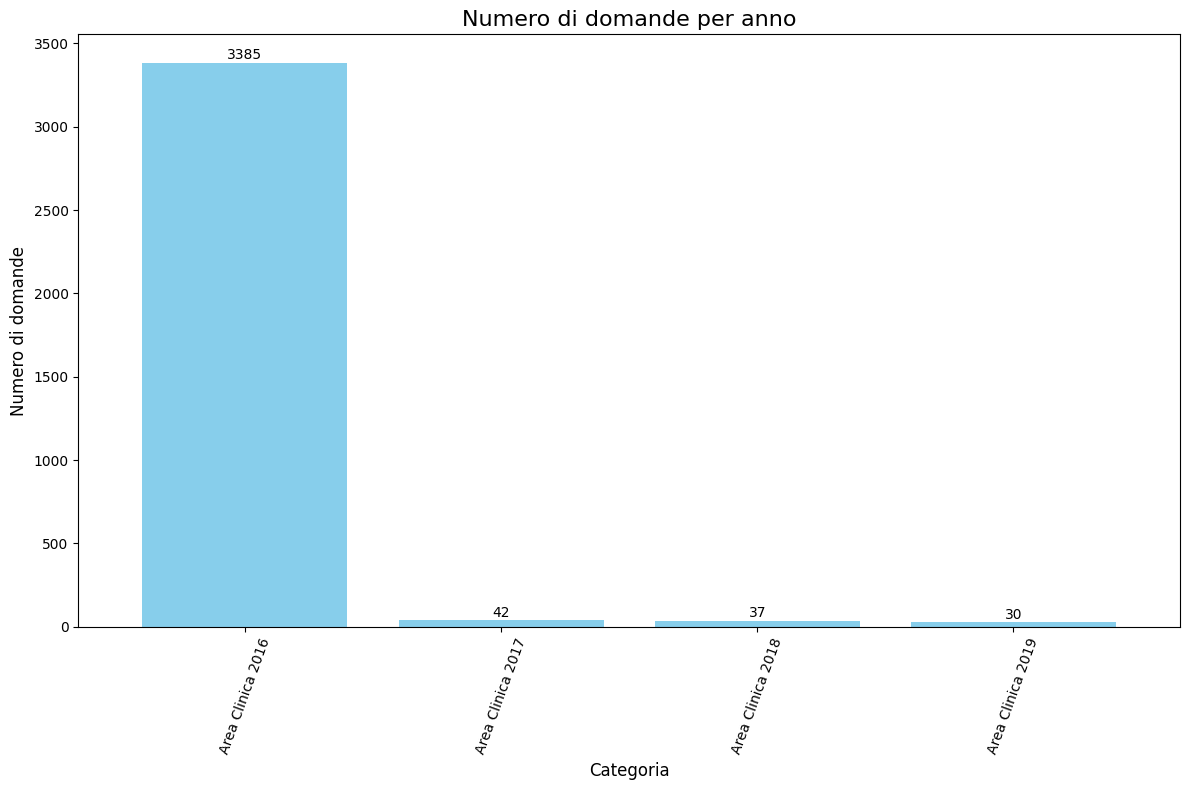

In [89]:


# Conta le domande per categoria
conteggio = df_filtrato['category'].value_counts()

# Imposta dimensioni della figura (larghezza, altezza in pollici)
plt.figure(figsize=(12, 8))

# Crea il grafico a barre con barre più larghe
ax = conteggio.plot(kind='bar', color='skyblue', width=0.8)

# Aggiungi titolo e label
plt.title('Numero di domande per anno', fontsize=16)
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Numero di domande', fontsize=12)
plt.xticks(rotation=70)

# Aggiungi il numero sopra ogni colonna
for i, value in enumerate(conteggio):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
